    Abstract
Currently, there is no prediction provided to users for the amount of time a particular data transfer from one site in the Worldwide LHC Computing Grid to another will take to complete. To develop a time-to-complete prediction, network performance data and per-file information is gathered from two separate databases and fused, and the resulting cleaned data is fitted using random forest regression. Results are shown for two separate links: the link from CERN Data Centre to Brookhaven National Laboratory’s ATLAS data center, and the link from CERN Data Centre to SARA-MATRIX in Amsterdam. A total RMS error of 25.93 minutes between predicted and test data is found for the CERN-PROD -> BNL-ATLAS link, while the CERN-PROD -> SARA-MATRIX link yields a total RMS error of 3.00 minutes.

    Introduction
The data taken at the Large Hadron Collider (LHC) are stored and distributed via the Worldwide LHC Computing Grid (WLCG), a network of computing centers and users across the globe. Currently, there is no prediction provided to users for the amount of time a particular data transfer from one site to another will take to complete. The goal of this project is to develop a model to predict the time-to-complete (TTC) of a file based on file size and type, including network status and performance at the time of file submission.

    Data Acquisition
The data for this model is taken from two different Elasticsearch databases, over a 4-week interval. Maintained by the University of Chicago, "rucio-events" is an ATLAS data management system that contains per-file information for all file transfers. The “ddm-metrics” data contains network performance and status information, and is aggregated from a database maintained at CERN.

Instead of taking all files from the four weeks, a random sample of 100 files per 10 minutes is gathered from rucio-events. This is done to avoid overfitting on intervals that contain many files submitted in a short period. Applying this sampling reduces the total size of the data considered by about one-half.

Within rucio-events, each file has a size in bytes and an activity type which depends on the file’s function. Finally, timestamps are recorded when the file is submitted to the queue, when the file begins transferring, and when the file has completed transferring. The TTC data that is used as the dependent variable within the regression model is computed from these timestamps.

Since certain activities are prioritized by the data transfer application, it is necessary to distinguish between activity type when constructing the model. In order to prepare the activity data for regression, each value is coded as an n-vector, where n is the number of distinct activities. For each observation, the index corresponding to the appropriate category holds a value of 1, and the rest of the indices are zero. For example, in the case of a variable with 3 possible categories the first is encoded [1,0,0], the second [0,1,0], and the third [0,0,1].

From ddm-metrics, throughput measures are acquired, as well as fields containing the number of files queued per activity. These fields are aggregated internally and updated at a rate of once every 5 or 10 minutes, depending on the field. For ease of comparison, these results are normalized to bin widths of 10 minutes, aggregating by sum for the queued fields and by mean for the throughput measures.

To connect the rucio-events data to the ddm-metrics data, each file from rucio-events is associated with the appropriate aggregated data bin from ddm-metrics by the file’s “submitted_at” timestamp. The joined dataset matrix rows are then sorted according to increasing “submitted_at” timestamp. Finally, any rows with missing values are not used for regression.

    Regression Model
Decision tree learning is an effective and efficient tool for classification and regression of large datasets, and may find nonlinear relationships between variables. Since decision trees are prone to overfitting, multiple random samples may be generated from the training data and fitted with separate decision trees. This method generates a forest of predictions that is averaged, producing a final prediction which is robust to outliers and noise, as shown by Breiman (2001). This project uses the Python library scikit-learn’s implementation of a random forest regressor, which produces continuous data as an output.

A training set is formed from the first 80% of the cleaned and sorted data, while the last 20% is reserved for validation. This choice of split is arbitrary: a 70/30 or 60/40 split could have been chosen (although preliminary results suggest that these choices cause an increase of outliers in predicted values). Fifty trees were chosen as the forest size.

    Results and Discussion
The intent of this project is to give a “ballpark” estimate for the time-to-complete of a file. As such, the regression model developed for this project performs well for the two links considered. Because the regression model performs poorly on activities with low file counts, those activities often yield a considerably higher RMSE, e.g., staging.

There are significant deviations at times. For example, the central plot in Figure 3, corresponding to the Production Input activity, displays high TTC for some data that is not captured by the model. This is especially evident in a histogram of the error difference, visible as a peak centered at approximately -140 minutes in the tail of the Production Input activity.

Because of the exploratory nature of this project, it is impossible to determine whether all significant variables have been considered in the model. Indeed, since the spikes in the TTC data are not always captured by the model, and the model occasionally predicts spikes that do not occur, there is evidence that an important component is missing.
There are two potential improvements to this model that come to mind. First, it is known that the transfer of data traveling in one direction along a link can affect the queue time of data flowing in the opposite direction, because of the read-write capabilities of the storage systems on either side. There is currently no measure for this influence, so it must be accepted as bias, but if in the future such a measure is implemented, it may be advantageous to add it to the model. Second, the current implementation of the regression model assumes that there is only one file being submitted at a given time. Knowledge of the number and size of files submitted simultaneously, or within a small time window, may improve the predictability of this model, especially for large batch submissions.

This work was supported by the U.S. National Science Foundation under Grant No. 1358071.

    References
Breiman, L. Machine Learning (2001) 45: 5. 

In [1]:
#These lines set up inline plotting, and apply a standard size
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import datetime
import re
from elasticsearch import Elasticsearch
matplotlib.rc('font', **{'size': 15})


src = 'CERN-PROD'
dst = 'BNL-ATLAS'

## it would be faster not do query string but to filter for src-rse and dst-rse and event_type.

In [2]:
query1 = '''{
    
  "size": 10000,
  "sort": [
    {
      "@timestamp": {
        "order": "random",
      }
    }
  ],
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "payload.src-rse:CERN* AND payload.dst-rse:BNL* AND event_type:transfer-done",
          "analyze_wildcard": True,
          "lowercase_expanded_terms": False
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "range": {
                "@timestamp": {
                  "gte": %i,
                  "lte": %i,
                  "format": "epoch_millis"
                }
              }
            }
          ],
          "must_not": []
        }
      }
    }
  },
  "fielddata_fields": [
    "@timestamp","duration"
  ]
}'''

In [3]:
import time

#Initialize convenient time intervals in milliseconds
milliWeek = 7*24*60*60*1000
milliTwoWeek = 2*7*24*60*60*1000
milliThreeWeek = 3*7*24*60*60*1000
milliFourWeek = 4*7*24*60*60*1000
milliSixHour = 12*60*60*1000
milliMonth = 30*24*60*60*1000
milliDay = 24*60*60*1000
milliHalfDay = 12*60*60*1000
milliHour = 60*60*1000

#currentMilliTime = int(round(time.time()*1000))

#Some time in August 14, 2016, just picked a time to compare across notebooks
currentMilliTime = 1471176912780

# Please don't search but scan through the data. 

In [4]:
import ast

#Get four weeks of data
start = currentMilliTime - milliFourWeek
end = currentMilliTime

hourSeg = 24*7*4
tenMinSeg = 24*7*4*6
milliTenMinutes = 1000*60*10

totalTimestamp = []
totalFileSize = []
totalActivity = []
totalStartedAt = []
totalSubmittedAt = []
totalTransferredAt = []

startPart = start
endPart = start

numNeighborsQueued = []

tic = time.time()

#Step through day, getting all data in range
for i in range(tenMinSeg):
    endPart += milliTenMinutes
    
    #Initialize lists
    fileSize = []
    activity = []
    startedAt = []
    submittedAt = []
    transferredAt = []
    duration = []
    
    #Create instance of ElasticSearch using the Atlas host server
    es1 = Elasticsearch(hosts=[{'host':'atlas-kibana-2.mwt2.org', 'port':9200}],
                        timeout=20,retry_on_timeout = True)
    response = es1.search(index="rucio-events*", body=ast.literal_eval(query1%(startPart,endPart)),
                          request_timeout=20)
    
    #Get important fields
    for r in response['hits']['hits']:
        fileSize.append(r['_source']['payload']['file-size'])
        activity.append(r['_source']['payload']['activity'])
        startedAt.append(r['_source']['payload']['started_at'])
        submittedAt.append(r['_source']['payload']['submitted_at'])
        transferredAt.append(r['_source']['payload']['transferred_at'])
    
    numNeighborsQueued.append([startPart + (endPart - startPart)/2, len(fileSize)])
    
    #Get random indices in range of length of data vectors
    if (len(fileSize) < 100) & (len(fileSize) > 0):
        #Grab all files if there are less than 100
        ind = np.random.choice(len(fileSize),size=len(fileSize),replace=False)
        
        #Append each random sample from the hour's data
        totalFileSize += [ fileSize[i] for i in ind]
        totalActivity += [ activity[i] for i in ind]
        totalStartedAt += [ startedAt[i] for i in ind]
        totalSubmittedAt += [ submittedAt[i] for i in ind]
        totalTransferredAt += [ transferredAt[i] for i in ind]
        
    elif len(fileSize) >= 100:
        #Otherwise just grab 100 randomly
        ind = np.random.choice(len(fileSize),size=100,replace=False)  
        #Append each random sample from the hour's data
        totalFileSize += [ fileSize[i] for i in ind]
        totalActivity += [ activity[i] for i in ind]
        totalStartedAt += [ startedAt[i] for i in ind]
        totalSubmittedAt += [ submittedAt[i] for i in ind]
        totalTransferredAt += [ transferredAt[i] for i in ind]
    
    np.random.seed()
    

    startPart = endPart + 1
    if i%500 == 0:
        print('%f%% of the way there...'%(100*(i/tenMinSeg)))

print("Done. Took %f seconds"%(time.time()-tic))   

0.000000% of the way there...
12.400794% of the way there...
24.801587% of the way there...
37.202381% of the way there...
49.603175% of the way there...
62.003968% of the way there...
74.404762% of the way there...
86.805556% of the way there...
99.206349% of the way there...
Done. Took 867.770942 seconds


Next, we acquire data from the ddm-metrics, 

In [5]:
#Create query template for ddm-metric data
queryTemp = '''{
  "size": 0,
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "src:%s AND dst:%s",
          "analyze_wildcard": True
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "range": {
                "timestamp": {
                  "gte": %i,
                  "lte": %i,
                  "format": "epoch_millis"
                }
              }
            }
          ],
          "must_not": []
        }
      }
    }
  },
  "aggs": {
    "2": {
      "date_histogram": {
        "field": "timestamp",
        "interval": "10m",
        "time_zone": "Europe/Berlin",
        "min_doc_count": 1,
        "extended_bounds": {
          "min": %i,
          "max": %i
        }
      },
  "aggs": {
    "1": {
          "sum": {
            "field": 'queued-total'
          }
        },
        "2": {
          "sum": {
            "field": 'queued-User_Subscriptions'
          }
        },
        "3": {
          "sum": {
            "field": 'queued-T0_Export'
          }
        },
        "4": {
          "sum": {
            "field": 'queued-Data_Consolidation'
          }
        },
        "5": {
          "sum": {
            "field": 'queued-Functional_Test'
          }
        },
        "6": {
          "sum": {
            "field": 'queued-Express'
          }
        },
        "7": {
          "sum": {
            "field": 'queued-Production_Input'
          }
        },
        "8": {
          "sum": {
            "field": 'queued-Production_Output'
          }
        },
        "9": {
          "sum": {
            "field": 'queued-Staging'
          }
        },
        "10": {
          "avg": {
            "field": 'done-total-1h'
          }
        },
        "11": {
          "avg": {
            "field": 'done-User_Subscriptions-1h'
          }
        },
        "12": {
          "avg": {
            "field": 'done-T0_Export-1h'
          }
        },
        "13": {
          "avg": {
            "field": 'done-Data_Consolidation-1h'
          }
        },
        "14": {
          "avg": {
            "field": 'done-Functional_Test-1h'
          }
        },
        "15": {
          "avg": {
            "field": 'done-Express-1h'
          }
        },
        "16": {
          "avg": {
            "field": 'done-Production_Input-1h'
          }
        },
        "17": {
          "avg": {
            "field": 'done-Production_Output-1h'
          }
        },
        "18": {
          "avg": {
            "field": 'done-Staging-1h'
              }
            },
        
        
        "19": {
          "avg": {
            "field": 'packetloss'
              }
            },
        "20": {
          "avg": {
            "field": 'mbps-dashb-1h'
              }
            },
        "21": {
          "avg": {
            "field": 'mbps-dashb-1d'
              }
            },
        "22": {
          "avg": {
            "field": 'mbps-fts-1h'
              }
            },
        "23": {
          "avg": {
            "field": 'mbps-fts-1d'
              }
            },
        "24": {
          "avg": {
            "field": 'mbps-fax-1h'
              }
            },
        "25": {
          "avg": {
            "field": 'mbps-fax-1d'
              }
            }
      }
    }
  }
}'''

In [6]:
tic = time.time()

#I have to break the data acquisition up into pieces so that Elasticsearch doesn't crash.
startPart = start
endPart = start
numDays = 4*7
response = []
for i in range(numDays):
    
    es2 = Elasticsearch(hosts=[{'host':'es-atlas.cern.ch', 'port':9202}],
                   http_auth=('es-atlas', 'v~$&<J8/cG9]*eQ@'),
                   timeout=20,retry_on_timeout=True)
    
    print("Loading data from Day %i..."%(i+1))
    endPart += milliDay  
    query = ast.literal_eval(queryTemp%(src,dst,startPart,endPart,startPart,endPart))
    response.append(es2.search(index="atlas_ddm-metrics*", body=query, request_timeout=20))
    startPart = endPart+1
    
print("Done. Aggregation took %f seconds"%(time.time()-tic))

Loading data from Day 1...
Loading data from Day 2...
Loading data from Day 3...
Loading data from Day 4...
Loading data from Day 5...
Loading data from Day 6...
Loading data from Day 7...
Loading data from Day 8...
Loading data from Day 9...
Loading data from Day 10...
Loading data from Day 11...
Loading data from Day 12...
Loading data from Day 13...
Loading data from Day 14...
Loading data from Day 15...
Loading data from Day 16...
Loading data from Day 17...
Loading data from Day 18...
Loading data from Day 19...
Loading data from Day 20...
Loading data from Day 21...
Loading data from Day 22...
Loading data from Day 23...
Loading data from Day 24...
Loading data from Day 25...
Loading data from Day 26...
Loading data from Day 27...
Loading data from Day 28...
Done. Aggregation took 704.084910 seconds


Next, we need to gather data about network health and activity volumes from ddm-metrics.

In [188]:
-

In [189]:
#Some useful functions for date conversion
import datetime
from datetime import datetime

def convertDateToDatetime(dates):
    '''
    Converts string dates to datetime objects
    '''
    datetimeDates = []
    
    for i in range(len(dates)):
        #Use decimal version if the date string contains a decimal point
        if dates[i].find('.')==-1:
            epoch = datetime.strptime(dates[i], "%Y-%m-%d %H:%M:%S")
        else:
            epoch = datetime.strptime(dates[i], "%Y-%m-%d %H:%M:%S.%f")
        datetimeDates.append(epoch)
    return datetimeDates

def convertDateToMilliEpoch(dates):
    '''
    Converts string dates to milliEpoch values.
    '''
    epochDates = []
    zeroEpoch = datetime.utcfromtimestamp(0)    
    for i in range(len(dates)):
        #Use decimal version if the date string contains a decimal point
        if dates[i].find('.')==-1:
            epoch = datetime.strptime(dates[i], "%Y-%m-%d %H:%M:%S")
        else:
            epoch = datetime.strptime(dates[i], "%Y-%m-%d %H:%M:%S.%f")
            
        epochDates.append((epoch - zeroEpoch).total_seconds() * 1000.0)
    return epochDates
        
        
    return datetimeDates

def getSecondsDifference(epochDatesStart,epochDatesFinal):
    diff = []
    for i in range(len(epochDatesStart)):
        diff.append((epochDatesFinal[i] - epochDatesStart[i]).total_seconds())
    
    return diff

#Convenience function that converts lists with None values to arrays with zeroes in their place.
def NoneToNum(noneList):
    numArray = np.nan_to_num(np.array(noneList,dtype=float,copy=True))
    return numArray

In [190]:
#Convert string timestamps to usable quantities for each file

timeInQueue = getSecondsDifference(convertDateToDatetime(totalSubmittedAt),
                                   convertDateToDatetime(totalStartedAt))
timeTotal = getSecondsDifference(convertDateToDatetime(totalSubmittedAt),
                                 convertDateToDatetime(totalTransferredAt))
timeInTransfer = getSecondsDifference(convertDateToDatetime(totalStartedAt),
                                      convertDateToDatetime(totalTransferredAt))

#May regress separately on these variables eventually to get prediction of both queue-time and transfer-time
timeInQueue = np.array(timeInQueue)
timeInTransfer = np.array(timeInTransfer)

#For now, just predict total time from this variable
timeTotal = np.array(timeTotal)


In [191]:
#Get times that each file is submitted at
submittedTimes = np.array(convertDateToMilliEpoch(totalSubmittedAt))

#Get indices for sorting all ddm-metrics variables in ascending order based on submission time
timeIndex = np.argsort(submittedTimes)

submittedTimesSorted = submittedTimes[timeIndex].copy()

#Sort ddm-metrics data
activity = np.array(totalActivity)[timeIndex]
filesize = np.array(totalFileSize)[timeIndex]
timeTotalSorted = timeTotal[timeIndex].copy()
timeInQueueSorted = timeInQueue[timeIndex].copy()
timeInTransferSorted = timeInTransfer[timeIndex].copy()

In order to regress based on activity, a categorical variable, the categories are converted to n-vectors, where n is the number of categories for the variable. For each observation, the index corresponding to the appropriate category holds a value of 1, and the rest of the indices are zero.

In [192]:
#Convert categories to n-vectors

uniqueActivities = np.unique(activity)
vec = np.zeros(len(uniqueActivities))

dummyActivity = []

for i in range(len(activity)):
    vecNew = vec.copy()
    vecNew[np.where(uniqueActivities == activity[i])] = 100
    dummyActivity.append(vecNew)
dummyActivity = np.array(dummyActivity)

In [193]:
#Additional metric in development, ignore for now
#temp = np.array(numNeighborsQueued,dtype=float,copy=True)
#neighborTime = temp[:,0]
#numNeighbors = temp[:,1]
#binIndex2 = np.digitize(submittedTimesSorted,neighborTime)-1

#numNeighbors2 = numNeighbors[binIndex2].copy()

In [194]:
timestamp = np.array(timestamp, dtype=float)

#Get indices that relate the two timescales between metrics, so that the correct network performance values may be
#associated with each file
binIndex = np.digitize(submittedTimesSorted,timestamp)-1

#Convert lists to arrays, and None objects to NaNs, for queued and done data. In these cases, NaNs represent the absence
#of files in the category, rather than actual missing data.
queuedTotal = NoneToNum(queuedTotal)[binIndex]
queuedUserSubscriptions = NoneToNum(queuedUserSubscriptions)[binIndex]
queuedT0Export = NoneToNum(queuedT0Export)[binIndex]
queuedStaging = NoneToNum(queuedStaging)[binIndex]
queuedDataConsolidation = NoneToNum(queuedDataConsolidation)[binIndex]
queuedFunctionalTest = NoneToNum(queuedFunctionalTest)[binIndex]
queuedExpress = NoneToNum(queuedExpress)[binIndex]
queuedProductionInput = NoneToNum(queuedProductionInput)[binIndex]
queuedProductionOutput = NoneToNum(queuedProductionOutput)[binIndex]
queuedStaging = NoneToNum(queuedStaging)[binIndex]

doneTotal = NoneToNum(doneTotal)[binIndex]
doneUserSubscriptions = NoneToNum(doneUserSubscriptions)[binIndex]
doneT0Export = NoneToNum(doneT0Export)[binIndex]
doneStaging = NoneToNum(doneStaging)[binIndex]
doneDataConsolidation = NoneToNum(doneDataConsolidation)[binIndex]
doneFunctionalTest = NoneToNum(doneFunctionalTest)[binIndex]
doneExpress = NoneToNum(doneExpress)[binIndex]
doneProductionInput = NoneToNum(doneProductionInput)[binIndex]
doneProductionOutput = NoneToNum(doneProductionOutput)[binIndex]
doneStaging = NoneToNum(doneStaging)[binIndex]

#Likewise, the packet loss parameter is only taken when it rises above a certain value, so empty values can safely be
#set to zero.
loss = NoneToNum(packetloss)[binIndex]


#Should these be kept as NaNs instead of making zero?
dashThroughput1h = NoneToNum(dashThroughput1h)[binIndex]
dashThroughput1d = NoneToNum(dashThroughput1d)[binIndex]
ftsThroughput1h = NoneToNum(ftsThroughput1h)[binIndex]
ftsThroughput1d = NoneToNum(ftsThroughput1d)[binIndex]
faxThroughput1h = NoneToNum(faxThroughput1h)[binIndex]
faxThroughput1d = NoneToNum(faxThroughput1d)[binIndex]

In [195]:
def convertSecsToCat(data):
    timeCategory = np.zeros(len(data),dtype=int)
    for i in range(len(data)):
        if data[i] < 600: #Less than 10 min
            timeCategory[i] = 0
        elif data[i] >= 600 and data[i] < 1200:#(10-20 min)
            timeCategory[i] = 1
        elif (data[i] >= 1200 and data[i] < 3600): #(between 20 min and 1 hour)
            timeCategory[i] = 2
        elif data[i] >=3600 and data[i] < 7200: #(between 1 and 2 hr)
            timeCategory[i] = 3
        elif data[i] >= 7200 and data[i] < 18000: #(2-5 hour)
            timeCategory[i] = 4
        elif data[i] >= 18000: #Greater than or equal to 5 hours
            timeCategory[i] = 5
    return timeCategory

In [196]:
from sklearn.ensemble import (GradientBoostingRegressor,RandomForestRegressor,AdaBoostRegressor,BaggingRegressor,
                              ExtraTreesRegressor)

#Form input by combining various variables.
inputSample = np.squeeze(np.hstack((submittedTimesSorted[:,None],queuedUserSubscriptions[:,None],
                                    queuedT0Export[:,None],queuedStaging[:,None],
                                    queuedDataConsolidation[:,None],queuedFunctionalTest[:,None],
                                    queuedExpress[:,None],queuedProductionInput[:,None],
                                    queuedProductionOutput[:,None],queuedStaging[:,None],queuedTotal[:,None],
                                    #doneUserSubscriptions[:,None],
                                    #doneT0Export[:,None],doneStaging[:,None],
                                    #doneDataConsolidation[:,None],doneFunctionalTest[:,None],
                                    #doneExpress[:,None],doneProductionInput[:,None],
                                    #doneProductionOutput[:,None],doneStaging[:,None],
                                    dashThroughput1h[:,None],ftsThroughput1h[:,None],dashThroughput1d[:,None],
                                    ftsThroughput1d[:,None],filesize[:,None],dummyActivity)))
outputSample = timeTotalSorted.copy()

#Find rows of data that contain at least one missing value
missing = np.isnan(np.sum(inputSample,axis=1))

reducedInput = inputSample[~missing].copy()
reducedOutput = outputSample[~missing].copy()
activity = activity[~missing].copy()


#First 80% of data to train on, and test on the last 20%
sp = int(round(0.80*len(reducedOutput)))

X_train = reducedInput[:sp,:].copy()
Y_train = reducedOutput[:sp].copy()
X_test = reducedInput[sp:].copy()
Y_test = reducedOutput[sp:].copy()

model = RandomForestRegressor(n_estimators=50)
Y_predict = model.fit(X_train[:,1:],Y_train).predict(X_test[:,1:])

    

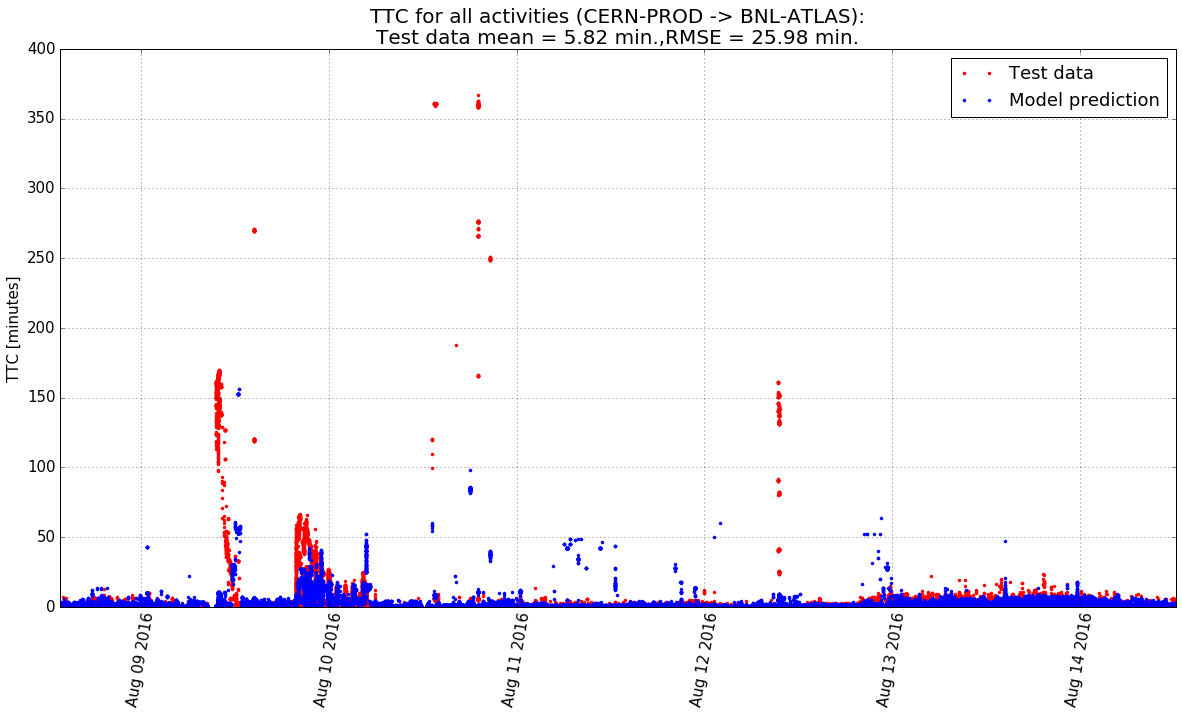

In [197]:
import matplotlib.dates as dt

dateTime = dt.epoch2num(X_test[:,0]/1000.)


plt.figure(figsize=(20,10))

plt.plot_date(dateTime,Y_test/60.,'r.',label='Test data')
plt.plot_date(dateTime,Y_predict/60.,'b.',label='Model prediction')
plt.ylabel("TTC [minutes]")

ax = plt.gca()
#Tedious date/time formatting
rms = np.sqrt(np.mean((Y_test/60.-Y_predict/60.)**2))
m = np.mean(Y_test/60.)
plt.xticks(rotation= 80 )
plt.grid()
plt.legend()
plt.title("TTC for all activities (CERN-PROD -> BNL-ATLAS):\nTest data mean = %.2f min.,RMSE = %.2f min."
          %(m,rms),size=20)

/home/ivukotic/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/ivukotic/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


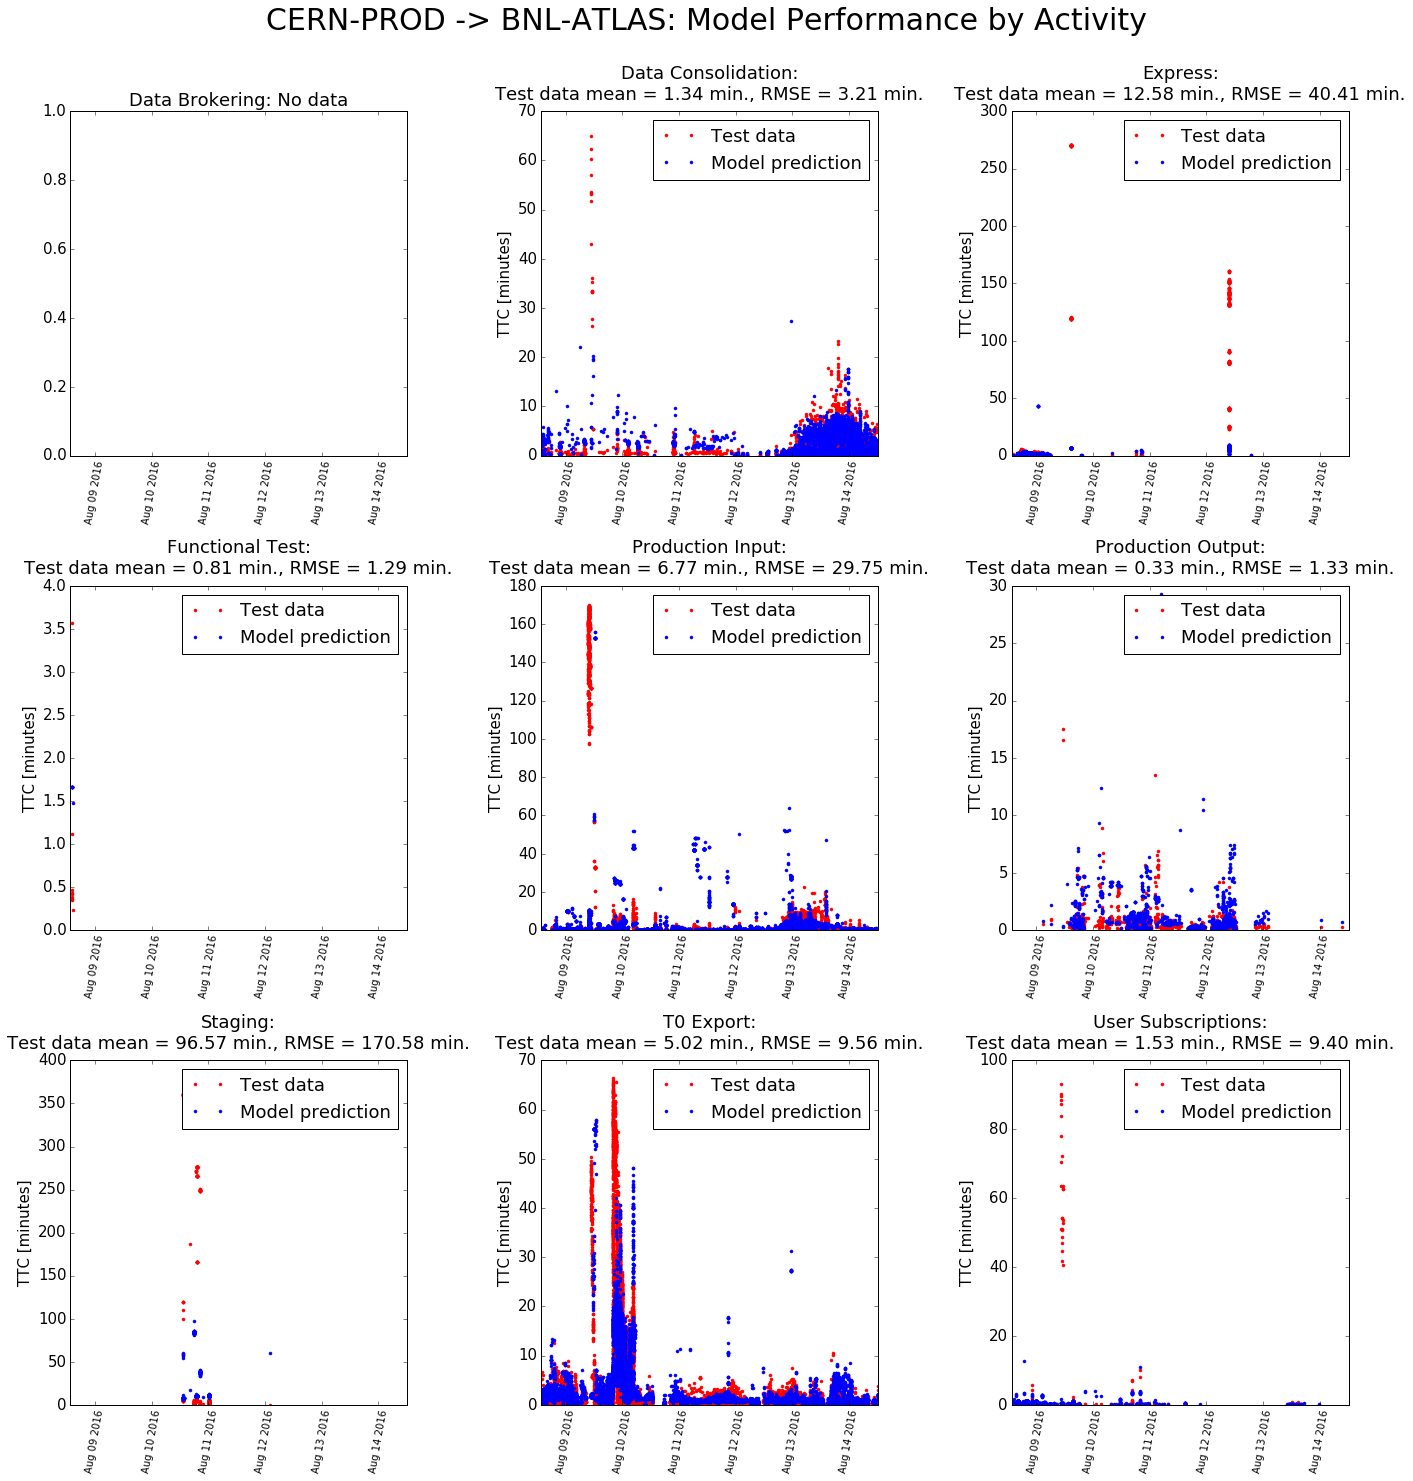

In [198]:
import matplotlib.dates as dt

plt.figure(figsize=(20,20))

uniqueActivities = np.unique(totalActivity)
for u in range(len(uniqueActivities)):
    plt.subplot(3,3,u+1,sharex=ax)
    currentIndex = np.array(activity[sp:])==uniqueActivities[u]
    
    dateTime = dt.epoch2num(X_test[currentIndex,0]/1000.)
    
    testMean = np.mean(Y_test[currentIndex]/60.)
    rms = np.sqrt(np.mean((Y_test[currentIndex]/60.-Y_predict[currentIndex]/60.)**2))

    if str(rms) == "nan":
        plt.title('%s: No data'%(uniqueActivities[u]))
        plt.xticks(rotation=80,size=10)
    else:
        
        plt.plot_date(dateTime,Y_test[currentIndex]/(60.),'r.',label='Test data')
        plt.plot_date(dateTime,Y_predict[currentIndex]/(60.),'b.',label='Model prediction')
        plt.ylabel('TTC [minutes]')
        plt.xticks(rotation=80,size=10)
        plt.title("%s:\nTest data mean = %.2f min., RMSE = %.2f min."%(uniqueActivities[u],testMean, rms),y=1.02)
        plt.legend()
        
plt.tight_layout()
plt.suptitle('CERN-PROD -> BNL-ATLAS: Model Performance by Activity',size=30,y=1.03)
plt.show()

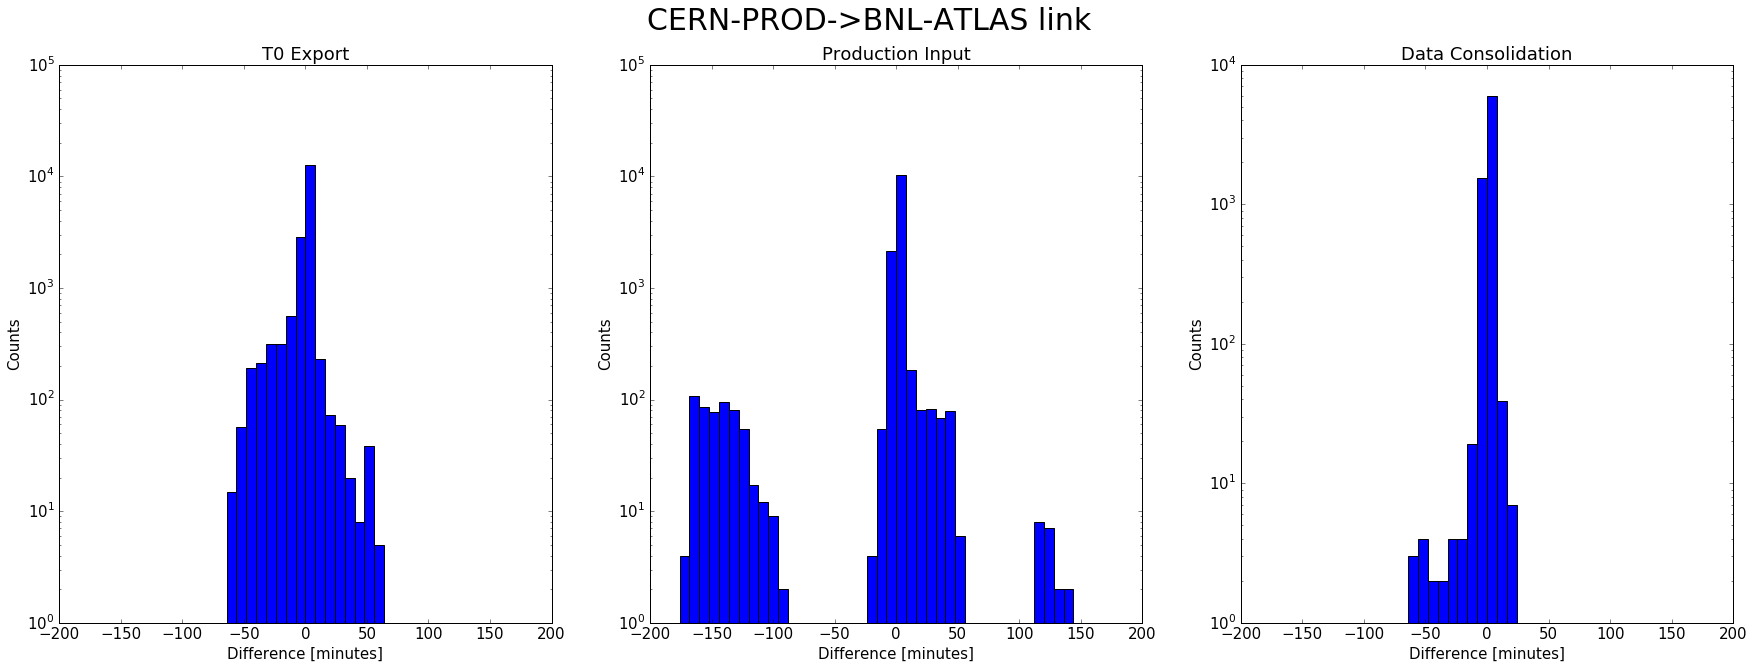

In [199]:
T0ExportIndex = np.array(activity[sp:])=="T0 Export"
productionInputIndex = np.array(activity[sp:])=="Production Input"
dataConsolidationIndex = np.array(activity[sp:])=="Data Consolidation"

plt.figure(figsize=(30,10))

plt.subplot(1,3,1)
plt.hist(Y_predict[T0ExportIndex]/60.-Y_test[T0ExportIndex]/60.,bins=50,
        range=[-200,200])
plt.xlim([-200,200])
plt.title('T0 Export')
plt.xlabel('Difference [minutes]')
plt.ylabel('Counts')
ax = plt.gca()
ax.set_yscale('log')


plt.subplot(1,3,2,sharey=ax)
plt.hist(Y_predict[productionInputIndex]/60.-Y_test[productionInputIndex]/60.,bins=50,
        range=[-200,200])
plt.xlim([-200,200])
plt.title('Production Input')
ax2 = plt.gca()
ax2.set_yscale('log')
plt.xlabel('Difference [minutes]')
plt.ylabel('Counts')


plt.subplot(1,3,3)
plt.hist(Y_predict[dataConsolidationIndex]/60.-Y_test[dataConsolidationIndex]/60.,bins=50,
         range=[-200,200])
plt.xlim([-200,200])
ax = plt.gca()
ax.set_yscale('log')
plt.xlabel('Difference [minutes]')
plt.ylabel('Counts')
plt.title('Data Consolidation')

plt.suptitle('CERN-PROD->BNL-ATLAS link',size=30)
plt.show()